In [1]:
cd "Model/Segmentacion"


/home/jupyter-pcarmona@alges.cl/Model/Segmentacion


In [ ]:
!git pull

: 

In [2]:
from data import *
from torch.utils.data import DataLoader
from torchvision import transforms



#datasets
BATCH_SIZE = 2
mode="material"
IMAGE_PATH, MASK_PATH = getpaths(mode)
df=create_df(mode)

train_set = OperationDataset(IMAGE_PATH, MASK_PATH, df['id'].values)
val_set = OperationDataset(IMAGE_PATH, MASK_PATH, df['id'].values)

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=True)

In [3]:
import optuna
import segmentation_models_pytorch as smp
import torch
def Objective(trial):
    ENCODER_NAME = 'resnet18'#'timm-regnetx_002'#trial.suggest_categorical('encoder',['resnet50','resnet18','timm-efficientnet-b1'])#'mobilenet_v2'  # 'mobilenet_v2', 'resnet50', 'resnet34'
    ENCODER_WEIGHTS = 'imagenet'  # None, 'imagenet', 'ssl', 'swsl'
    EPOCHS = 7
    ENCODER_DEPTH = 3
    POOLING = 'avg'  #  'avg', 'max'
    DROPOUT = 0.1
    CHANS=3
    def getShed(arg):
        if arg == 'Steplr':
            sched= torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
        elif arg == 'Cycliclr':
            sched = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.00001, max_lr=LR, step_size_up=5, mode='triangular2',cycle_momentum=False)
        elif arg == 'OneCycle':
            sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, LR, epochs=EPOCHS,steps_per_epoch=len(train_loader))
        return sched


    model=getModel('unet++')#getModel(trial.suggest_categorical('model', ['unet','unet++','fpn','linknet']))
    LR = trial.suggest_float('lr', 1e-5, 1e-2)
    WEIGHT_DECAY = 0.004#trial.suggest_float('weight_decay', 1e-5, 1e-2)
    #criterion = trial.suggest_categorical('criterion', ['LV','DL','Focal','Tversky'])
    criterion = getCriterion('Tversky')#getCriterion(trial.suggest_categorical('criterion', ['LV','DL','Focal','Tversky','Custom']))
    
    # optimizer = torch.optim.Adam([dict(params=model.parameters(), lr=LR),])
    optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

    sched = getShed(trial.suggest_categorical('sched', ['Steplr','Cycliclr','OneCycle']))
    
    


    history = fit(EPOCHS, model, train_loader, val_loader, criterion, optimizer, sched, mode)
    return history['val_miou'][-1]
nt=50
study_name = 'Material+Tversky+Unet++'  # Unique identifier of the study.
storage_name = 'sqlite:///optuna.db'  # Storage in DB.
study = optuna.create_study(direction='maximize',load_if_exists=True, study_name=study_name, storage=storage_name, sampler=optuna.samplers.TPESampler(),pruner=optuna.pruners.SuccessiveHalvingPruner())
study.optimize(Objective, n_trials=nt)


[I 2023-04-26 14:34:30,528] Using an existing study with name 'Material+Tversky+Unet++' instead of creating a new one.
/home/jupyter-pcarmona@alges.cl/.local/lib/python3.9/site-packages/torch/cuda/__init__.py:123: UserWarning: 
    Found GPU1 Tesla K40c which is of cuda capability 3.5.
    PyTorch no longer supports this GPU because it is too old.
    The minimum cuda capability supported by this library is 3.7.
    
  warnings.warn(old_gpu_warn % (d, name, major, minor, min_arch // 10, min_arch % 10))


  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

Loss Decreasing.. inf >> 0.328 
saving model...
Epoch:1/7.. Train Loss: 0.357.. Val Loss: 0.328.. Train mIoU:0.312.. Val mIoU: 0.368.. Train Acc:0.900.. Val Acc:0.982.. Time: 0.38m


  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

Loss Decreasing.. 0.328 >> 0.324 
saving model...
Epoch:2/7.. Train Loss: 0.331.. Val Loss: 0.324.. Train mIoU:0.357.. Val mIoU: 0.373.. Train Acc:0.979.. Val Acc:0.982.. Time: 0.38m


  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

Loss Decreasing.. 0.324 >> 0.311 
saving model...
Epoch:3/7.. Train Loss: 0.328.. Val Loss: 0.311.. Train mIoU:0.363.. Val mIoU: 0.393.. Train Acc:0.979.. Val Acc:0.980.. Time: 0.38m


  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

Loss Not Decrease for 1 time
Epoch:4/7.. Train Loss: 0.336.. Val Loss: 0.315.. Train mIoU:0.357.. Val mIoU: 0.380.. Train Acc:0.982.. Val Acc:0.980.. Time: 0.38m


  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

Loss Not Decrease for 2 time
Epoch:5/7.. Train Loss: 0.324.. Val Loss: 0.325.. Train mIoU:0.372.. Val mIoU: 0.373.. Train Acc:0.980.. Val Acc:0.984.. Time: 0.38m


  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

Loss Decreasing.. 0.325 >> 0.311 
saving model...
Epoch:6/7.. Train Loss: 0.314.. Val Loss: 0.311.. Train mIoU:0.389.. Val mIoU: 0.388.. Train Acc:0.981.. Val Acc:0.980.. Time: 0.38m


  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

[I 2023-04-26 14:37:12,858] Trial 1 finished with value: 0.39487543558679444 and parameters: {'lr': 0.007528904872241404, 'sched': 'Cycliclr'}. Best is trial 1 with value: 0.39487543558679444.


Loss Not Decrease for 3 time
Epoch:7/7.. Train Loss: 0.323.. Val Loss: 0.312.. Train mIoU:0.375.. Val mIoU: 0.395.. Train Acc:0.980.. Val Acc:0.979.. Time: 0.38m
Total time: 2.66 m


  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

Loss Decreasing.. inf >> 0.383 
saving model...
Epoch:1/7.. Train Loss: 0.404.. Val Loss: 0.383.. Train mIoU:0.260.. Val mIoU: 0.290.. Train Acc:0.740.. Val Acc:0.974.. Time: 0.38m


  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

Loss Decreasing.. 0.383 >> 0.383 
saving model...
Epoch:2/7.. Train Loss: 0.320.. Val Loss: 0.383.. Train mIoU:0.367.. Val mIoU: 0.251.. Train Acc:0.981.. Val Acc:0.623.. Time: 0.38m


  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

Loss Decreasing.. 0.383 >> 0.307 
saving model...
Epoch:3/7.. Train Loss: 0.318.. Val Loss: 0.307.. Train mIoU:0.367.. Val mIoU: 0.387.. Train Acc:0.975.. Val Acc:0.973.. Time: 0.38m


  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

Loss Not Decrease for 1 time
Epoch:4/7.. Train Loss: 0.295.. Val Loss: 0.374.. Train mIoU:0.398.. Val mIoU: 0.198.. Train Acc:0.978.. Val Acc:0.451.. Time: 0.38m


  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

Loss Decreasing.. 0.374 >> 0.361 
saving model...
Epoch:5/7.. Train Loss: 0.283.. Val Loss: 0.361.. Train mIoU:0.410.. Val mIoU: 0.273.. Train Acc:0.981.. Val Acc:0.767.. Time: 0.38m


  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

Loss Decreasing.. 0.361 >> 0.258 
saving model...
Epoch:6/7.. Train Loss: 0.267.. Val Loss: 0.258.. Train mIoU:0.437.. Val mIoU: 0.450.. Train Acc:0.980.. Val Acc:0.984.. Time: 0.38m


  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

[I 2023-04-26 14:39:53,351] Trial 2 finished with value: 0.47785506785295045 and parameters: {'lr': 0.006091867163165766, 'sched': 'OneCycle'}. Best is trial 2 with value: 0.47785506785295045.


Loss Decreasing.. 0.258 >> 0.244 
saving model...
Epoch:7/7.. Train Loss: 0.251.. Val Loss: 0.244.. Train mIoU:0.465.. Val mIoU: 0.478.. Train Acc:0.981.. Val Acc:0.984.. Time: 0.38m
Total time: 2.66 m


  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

Loss Decreasing.. inf >> 0.360 
saving model...
Epoch:1/7.. Train Loss: 0.359.. Val Loss: 0.360.. Train mIoU:0.311.. Val mIoU: 0.319.. Train Acc:0.919.. Val Acc:0.981.. Time: 0.38m


  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

Loss Decreasing.. 0.360 >> 0.333 
saving model...
Epoch:2/7.. Train Loss: 0.348.. Val Loss: 0.333.. Train mIoU:0.343.. Val mIoU: 0.351.. Train Acc:0.979.. Val Acc:0.979.. Time: 0.38m


  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

Loss Not Decrease for 1 time
Epoch:3/7.. Train Loss: 0.341.. Val Loss: 0.346.. Train mIoU:0.342.. Val mIoU: 0.336.. Train Acc:0.978.. Val Acc:0.977.. Time: 0.38m


  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

Loss Decreasing.. 0.346 >> 0.338 
saving model...
Epoch:4/7.. Train Loss: 0.339.. Val Loss: 0.338.. Train mIoU:0.346.. Val mIoU: 0.349.. Train Acc:0.978.. Val Acc:0.977.. Time: 0.38m


  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

Loss Not Decrease for 2 time
Epoch:5/7.. Train Loss: 0.330.. Val Loss: 0.340.. Train mIoU:0.351.. Val mIoU: 0.347.. Train Acc:0.979.. Val Acc:0.981.. Time: 0.38m


  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

Loss Decreasing.. 0.340 >> 0.328 
saving model...
Epoch:6/7.. Train Loss: 0.334.. Val Loss: 0.328.. Train mIoU:0.353.. Val mIoU: 0.360.. Train Acc:0.977.. Val Acc:0.980.. Time: 0.38m


  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

[I 2023-04-26 14:42:33,705] Trial 3 finished with value: 0.36152289962321776 and parameters: {'lr': 0.009711500368693896, 'sched': 'Cycliclr'}. Best is trial 2 with value: 0.47785506785295045.


Loss Decreasing.. 0.328 >> 0.326 
saving model...
Epoch:7/7.. Train Loss: 0.336.. Val Loss: 0.326.. Train mIoU:0.352.. Val mIoU: 0.362.. Train Acc:0.978.. Val Acc:0.978.. Time: 0.38m
Total time: 2.66 m


  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

Loss Decreasing.. inf >> 0.331 
saving model...
Epoch:1/7.. Train Loss: 0.368.. Val Loss: 0.331.. Train mIoU:0.318.. Val mIoU: 0.381.. Train Acc:0.909.. Val Acc:0.975.. Time: 0.38m


  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

Loss Decreasing.. 0.331 >> 0.328 
saving model...
Epoch:2/7.. Train Loss: 0.327.. Val Loss: 0.328.. Train mIoU:0.378.. Val mIoU: 0.384.. Train Acc:0.978.. Val Acc:0.979.. Time: 0.38m


  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

Loss Decreasing.. 0.328 >> 0.318 
saving model...
Epoch:3/7.. Train Loss: 0.328.. Val Loss: 0.318.. Train mIoU:0.377.. Val mIoU: 0.400.. Train Acc:0.980.. Val Acc:0.979.. Time: 0.38m


  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

Loss Decreasing.. 0.318 >> 0.317 
saving model...
Epoch:4/7.. Train Loss: 0.326.. Val Loss: 0.317.. Train mIoU:0.380.. Val mIoU: 0.399.. Train Acc:0.978.. Val Acc:0.980.. Time: 0.38m


  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

Loss Decreasing.. 0.317 >> 0.314 
saving model...
Epoch:5/7.. Train Loss: 0.322.. Val Loss: 0.314.. Train mIoU:0.386.. Val mIoU: 0.403.. Train Acc:0.979.. Val Acc:0.983.. Time: 0.38m


  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

Loss Decreasing.. 0.314 >> 0.313 
saving model...
Epoch:6/7.. Train Loss: 0.313.. Val Loss: 0.313.. Train mIoU:0.397.. Val mIoU: 0.405.. Train Acc:0.983.. Val Acc:0.983.. Time: 0.38m


  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

[I 2023-04-26 14:45:14,336] Trial 4 finished with value: 0.40065191569727165 and parameters: {'lr': 0.007502161228213999, 'sched': 'Cycliclr'}. Best is trial 2 with value: 0.47785506785295045.


Loss Not Decrease for 1 time
Epoch:7/7.. Train Loss: 0.312.. Val Loss: 0.315.. Train mIoU:0.396.. Val mIoU: 0.401.. Train Acc:0.981.. Val Acc:0.984.. Time: 0.38m
Total time: 2.67 m


  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

Loss Decreasing.. inf >> 0.322 
saving model...
Epoch:1/7.. Train Loss: 0.364.. Val Loss: 0.322.. Train mIoU:0.316.. Val mIoU: 0.378.. Train Acc:0.926.. Val Acc:0.978.. Time: 0.38m


  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

Loss Decreasing.. 0.322 >> 0.321 
saving model...
Epoch:2/7.. Train Loss: 0.328.. Val Loss: 0.321.. Train mIoU:0.363.. Val mIoU: 0.378.. Train Acc:0.980.. Val Acc:0.981.. Time: 0.38m


  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

Loss Not Decrease for 1 time
Epoch:3/7.. Train Loss: 0.334.. Val Loss: 0.335.. Train mIoU:0.359.. Val mIoU: 0.360.. Train Acc:0.979.. Val Acc:0.979.. Time: 0.38m


  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

Loss Decreasing.. 0.335 >> 0.313 
saving model...
Epoch:4/7.. Train Loss: 0.325.. Val Loss: 0.313.. Train mIoU:0.365.. Val mIoU: 0.394.. Train Acc:0.981.. Val Acc:0.984.. Time: 0.38m


  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

Loss Decreasing.. 0.313 >> 0.311 
saving model...
Epoch:5/7.. Train Loss: 0.316.. Val Loss: 0.311.. Train mIoU:0.379.. Val mIoU: 0.382.. Train Acc:0.982.. Val Acc:0.981.. Time: 0.38m


  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

Loss Not Decrease for 2 time
Epoch:6/7.. Train Loss: 0.328.. Val Loss: 0.318.. Train mIoU:0.363.. Val mIoU: 0.384.. Train Acc:0.983.. Val Acc:0.982.. Time: 0.38m


  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

[I 2023-04-26 14:47:55,139] Trial 5 finished with value: 0.3759784667047826 and parameters: {'lr': 0.009069126219174396, 'sched': 'Cycliclr'}. Best is trial 2 with value: 0.47785506785295045.


Loss Not Decrease for 3 time
Epoch:7/7.. Train Loss: 0.333.. Val Loss: 0.325.. Train mIoU:0.362.. Val mIoU: 0.376.. Train Acc:0.983.. Val Acc:0.980.. Time: 0.38m
Total time: 2.67 m


  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

Loss Decreasing.. inf >> 0.373 
saving model...
Epoch:1/7.. Train Loss: 0.428.. Val Loss: 0.373.. Train mIoU:0.209.. Val mIoU: 0.301.. Train Acc:0.624.. Val Acc:0.980.. Time: 0.38m


  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

Loss Not Decrease for 1 time
Epoch:2/7.. Train Loss: 0.334.. Val Loss: 0.455.. Train mIoU:0.355.. Val mIoU: 0.113.. Train Acc:0.979.. Val Acc:0.357.. Time: 0.38m


  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

In [5]:
import matplotlib.pyplot as plt
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
x=OperationDataset(getpaths('baches')[0],getpaths('baches')[1],df['id'].values)
model="modelnamemIoU-0.518.pt"
model=torch.load(model)
model.to(device)
model.eval()
len(x)

/home/jupyter-pcarmona@alges.cl/.local/lib/python3.9/site-packages/torch/cuda/__init__.py:123: UserWarning: 
    Found GPU1 Tesla K40c which is of cuda capability 3.5.
    PyTorch no longer supports this GPU because it is too old.
    The minimum cuda capability supported by this library is 3.7.
    
  warnings.warn(old_gpu_warn % (d, name, major, minor, min_arch // 10, min_arch % 10))


140

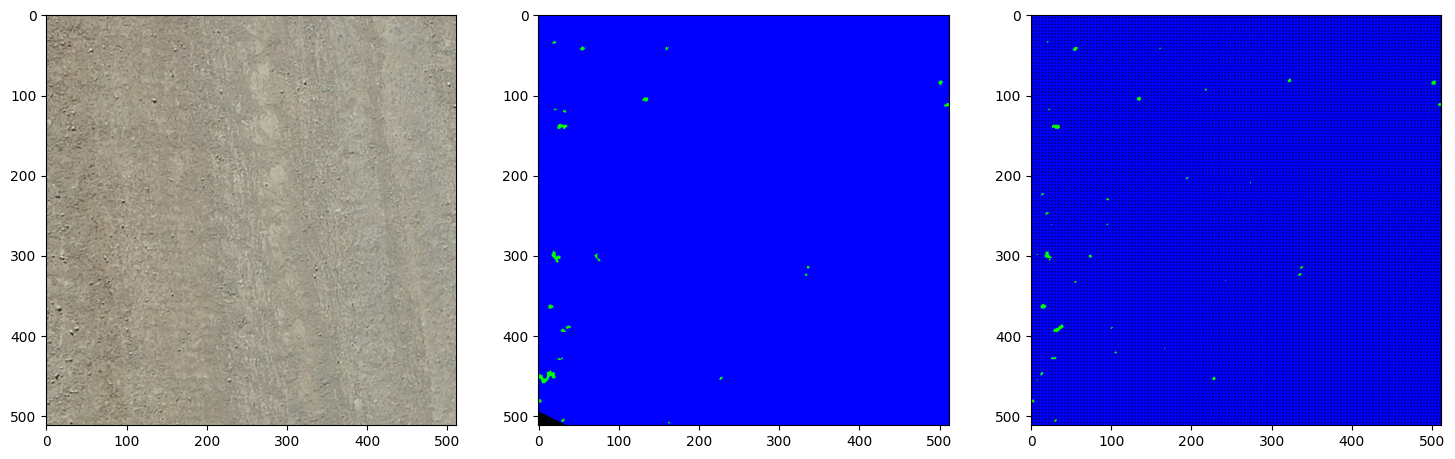

In [73]:
from ipywidgets import interact
import torch
def load(id):
    img=np.load(getpaths(mode)[0]+str(id)+'.npz')['arr_0'][:,:,:3]
    mask=np.load(getpaths(mode)[1]+str(id)+'.npz')['arr_0']
    return img,mask
def plot(id,pred=None):
    img,mask=load(id)
    if pred is not None:
        fig, ax =  plt.subplots(1, 3, figsize=(18,18))
    else:
        fig, ax =  plt.subplots(1, 2, figsize=(18,18))
    #set fixed colors of mask and pred for 7 classes
    colors = np.array([[0, 0, 0], [0, 0, 255], [0, 255, 0], [255, 0, 0], [255, 255, 0], [255, 0, 255], [0, 255, 255]])
    mask = colors[mask]
    if pred is not None:
        pred = colors[pred]
    ax[0].imshow(img)
    ax[1].imshow(mask)
    if pred is not None:
        ax[2].imshow(pred)
    plt.show()
def pred(id):
    img,mask=load(id)
    img=torch.from_numpy(img).permute(2,0,1).unsqueeze(0).float()
    pred=model(img.to(device))
    pred=torch.argmax(pred, dim=1).cpu().squeeze().detach().numpy()
    plot(id,pred)

pred(i)
i+=1


In [5]:
data=OperationDataset(getpaths('baches')[0],getpaths('baches')[1],df['id'].values)
len(data)
    

326

In [23]:
import ipywidgets as widgets
from ipywidgets import interact
%matplotlib inline

x=train_set.__getitem__(0)[0]
x=np.moveaxis(x,0,-1)
def dataplot(id):
    img, mask=train_set.__getitem__(id)
    img=np.moveaxis(img,0,-1)
    #normalize img
    mean=[np.mean(img[:,:,i]) for i in range(3)]
    std=[np.std(img[:,:,i]) for i in range(3)]
    #img=(img-mean)/std
    fig, ax =  plt.subplots(1, 2, figsize=(18,18))
    ax[0].imshow(img.astype('uint8'))
    ax[1].imshow(mask)
    plt.show()
#dataplot(36)
interact(dataplot, id=(0, len(train_set)-1, 1))

interactive(children=(IntSlider(value=69, description='id', max=139), Output()), _dom_classes=('widget-interac…

<function __main__.dataplot(id)>

In [7]:
from data import *

x=iter_mask('surcos')

In [9]:
len(x)

522